In [1]:
import sys
sys.path.append('../')

try:
    from ..spn_simulator.components.spn import *
    from ..spn_simulator.components.spn_visualization import *
    from ..spn_simulator.components.spn_simulate import *
    from ..spn_simulator.components.spn_io import *
except:
    from spn_simulator.components.spn import *
    from spn_simulator.components.spn_visualization import *
    from spn_simulator.components.spn_simulate import *
    from spn_simulator.components.spn_io import *

import pandas as pd
import pm4py

In [2]:
event_log = pd.read_csv ('raw_data/event_log.csv', sep=";", converters={"order_id":str})
state_log = pd.read_csv ('raw_data/state_log.csv', sep=";")
event_log['timestamp'] = event_log['timestamp'].str.replace('CET|CEST', '', regex=True)
event_log['timestamp'] = pd.to_datetime(event_log['timestamp']).dt.tz_localize('Europe/Berlin')

In [3]:
#WSC22 Data (parallel line)
#event_log = pd.read_csv ('raw_data/event_log_wsc22.csv', sep=";", converters={"order_id":str})
#event_log['timestamp'] = event_log['timestamp'].str.replace('CET|CEST', '', regex=True)
#event_log['timestamp'] = pd.to_datetime(event_log['timestamp']).dt.tz_localize('Europe/Berlin')

In [4]:
event_log.head()

,timestamp,order_id,resource,event
0,2023-04-18 00:00:00+02:00,260,MES,new_order
1,2023-04-18 00:00:00+02:00,260,cell1,cell1_operation
2,2023-04-18 00:00:01+02:00,260,cell2,cell2_operation
3,2023-04-18 00:00:01+02:00,261,MES,new_order
4,2023-04-18 00:00:01+02:00,261,cell1,cell1_operation


In [5]:
state_log.head()

,timestamp,resource,state
0,Tue Apr 18 00:00:00 CEST 2023,cell1,busy
1,Tue Apr 18 00:00:01 CEST 2023,cell1,idle
2,Tue Apr 18 00:00:01 CEST 2023,cell2,busy
3,Tue Apr 18 00:00:01 CEST 2023,cell1,busy
4,Tue Apr 18 00:00:02 CEST 2023,cell2,idle


In [6]:
net, im, fm = pm4py.discover_petri_net_alpha(event_log, activity_key='event', case_id_key='order_id', timestamp_key='timestamp')

In [7]:
#net, im, fm = pm4py.discover_petri_net_inductive(event_log, activity_key='event', case_id_key='order_id', timestamp_key='timestamp', noise_threshold = 0.1)

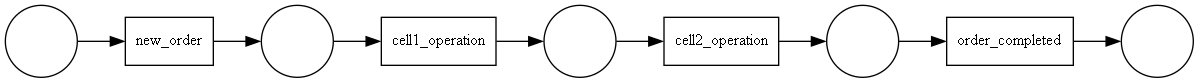

In [8]:
pm4py.view_petri_net(net)

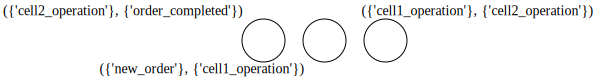

In [9]:
spn = SPN()

for place in net.places:
    if "start" not in str(place) and "end" not in str(place):
        new_place = Place(label=str(place), n_tokens=0)
        spn.add_place(new_place)

draw_spn(spn, show=False)

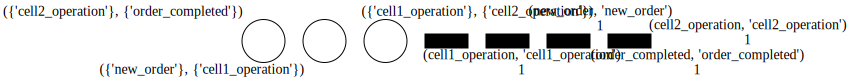

In [10]:
for transition in net.transitions:
    new_transition = Transition(label=str(transition),t_type="I")
    spn.add_transition(new_transition)

draw_spn(spn, show=False)

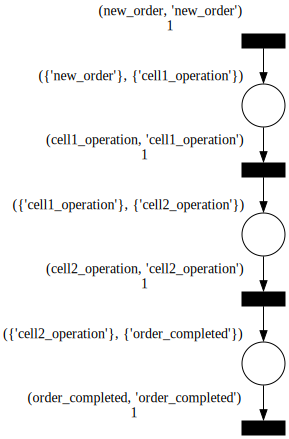

In [11]:
for arc in net.arcs:
    if "start" not in str(arc) and "end" not in str(arc):
        for transition in spn.transitions:
            if str(arc.source) == transition.label:
                spn.add_output_arc(transition,spn.get_place_by_label(str(arc.target)))
            if str(arc.target) == transition.label:
                spn.add_input_arc(spn.get_place_by_label(str(arc.source)),transition)

draw_spn(spn, show=False)

In [12]:
import re

for transition in spn.transitions:
    transition.label = re.sub(r'[^\w,]', '',transition.label.split(",")[0])

In [13]:
for place in spn.places:
    place.label = re.sub(r'[^\w,]', '', place.label)

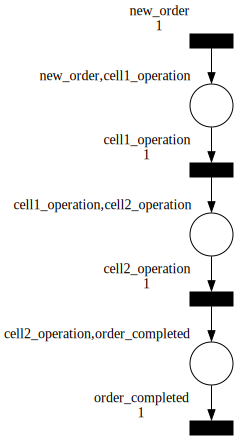

In [14]:
draw_spn(spn, show=False)

In [135]:
for transition in spn.transitions:
    transition:Transition
    if transition.input_arcs == []:
        transition.t_type = "T"
        transition.distribution 
    

[]


Estimation of Arrival Time Dist

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as ss
from fitter import Fitter, get_common_distributions, get_distributions

In [38]:
event_log.head()

,timestamp,order_id,resource,event,start_timestamp
0,2023-04-18 00:00:00+02:00,260,MES,new_order,2023-04-18 00:00:00+02:00
1,2023-04-18 00:00:00+02:00,260,cell1,cell1_operation,2023-04-18 00:00:00+02:00
2,2023-04-18 00:00:01+02:00,260,cell2,cell2_operation,2023-04-18 00:00:01+02:00
3,2023-04-18 00:00:01+02:00,261,MES,new_order,2023-04-18 00:00:01+02:00
4,2023-04-18 00:00:01+02:00,261,cell1,cell1_operation,2023-04-18 00:00:01+02:00


In [39]:
arrival_times = list(event_log[event_log["event"]=="new_order"]["timestamp"])
arrival_times_td =[(x-y).seconds for x, y in zip(arrival_times[1:], arrival_times)]

(array([358., 392., 153.,   0.,  57.,  15.,   0.,   9.,   1.,   1.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

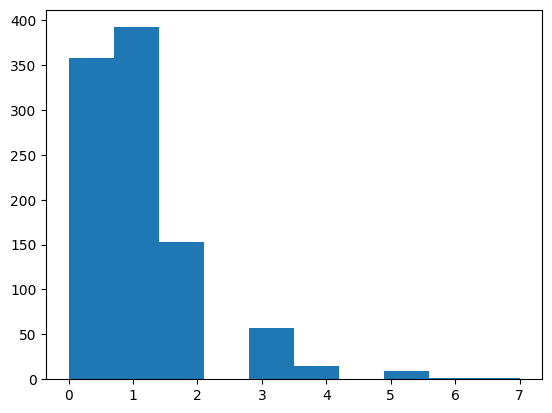

In [40]:
plt.hist(arrival_times_td)

In [150]:
f = Fitter(arrival_times_td,
           distributions=["expon","lognorm","norm","weibull_min","gamma"])
f.fit(progress=False)
f.summary()

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  7.75it/s]


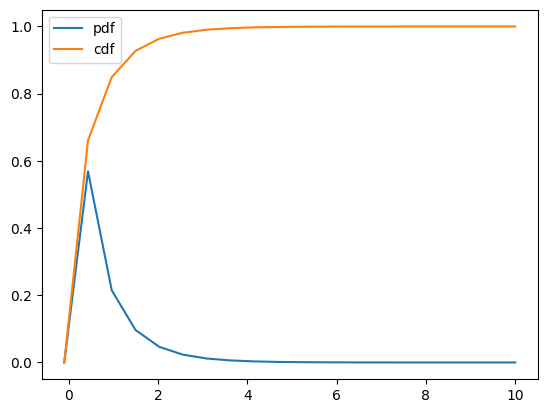

In [68]:
x = np.linspace(-0.1,10,20)
y_pdf = ss.gamma.pdf(x, 0.5131145929384269, -3.594519388615156e-27, 0.9118687392734223) # the normal pdf
y_cdf = ss.gamma.cdf(x, 0.5131145929384269, -3.594519388615156e-27, 0.9118687392734223) 


plt.plot(x, y_pdf, label='pdf')
plt.plot(x, y_cdf, label='cdf')
plt.legend()

In [136]:
f.get_best(method = 'sumsquare_error')

{'gamma': {'a': 0.5131145929384269,
  'loc': -3.594519388615156e-27,
  'scale': 0.9118687392734223}}

{'gamma': {'a': 0.5131145929384269,
  'loc': -3.594519388615156e-27,
  'scale': 0.9118687392734223}}

In [176]:
f.fitted_param

{'expon': (0.0, 1.0010141987829615),
 'norm': (1.0010141987829615, 1.0460972508405921),
 'gamma': (0.5131145929384269, -3.594519388615156e-27, 0.9118687392734223),
 'weibull_min': (0.753203385749286,
  -7.562656774758199e-30,
  1.3486139274934752),
 'lognorm': (7.870213716005244, -6.099264249801905e-23, 0.029835951299317306)}

In [92]:
best_dist = f.get_best(method = 'sumsquare_error')

In [96]:
import scipy.stats as sp

In [126]:
dist = ss.gamma(0.5131145929384269, -3.594519388615156e-27, 0.9118687392734223)
dist.rvs()

0.7004304386865837

In [22]:
arrival_transitions = spn.get_arrival_transitions()

transition:Transition
for transition in arrival_transitions:
    transition.t_type = "T"
    transition.distribution = list(best_dist)[0]
    transition.scipy_params = f.fitted_param[list(best_dist)[0]]


    